<a href="https://colab.research.google.com/github/ui-fankfurt/clv_prediction/blob/main/Fintech_CLV_v1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install lifetimes

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 584.2/584.2 kB 4.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 5.0 MB/s eta 0:00:00


# First Attempt
Code referred [here](https://medium.com/@yassirafif/projecting-customer-lifetime-value-using-the-bg-nbd-and-the-gamma-gamma-models-9a937c60fe7f)

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.metrics import mean_squared_error
from lifetimes import BetaGeoFitter
from lifetimes import GammaGammaFitter
from lifetimes.utils import calibration_and_holdout_data
from lifetimes.utils import summary_data_from_transaction_data
from lifetimes.plotting import plot_calibration_purchases_vs_holdout_purchases
from decimal import Decimal
import datetime as dt
from yellowbrick.cluster import KElbowVisualizer


In [ ]:
df = pd.read_excel('online_retail.xlsx')


In [ ]:
df

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
...,...,...,...,...,...,...,...,...
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,2011-12-09 12:50:00,0.85,12680.0,France
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2011-12-09 12:50:00,2.10,12680.0,France
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,2011-12-09 12:50:00,4.15,12680.0,France
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,2011-12-09 12:50:00,4.15,12680.0,France


In [ ]:
df.describe()

,Quantity,UnitPrice,CustomerID
count,541909.000000,541909.000000,406829.000000
mean,9.552250,4.611114,15287.690570
std,218.081158,96.759853,1713.600303
min,-80995.000000,-11062.060000,12346.000000
25%,1.000000,1.250000,13953.000000
50%,3.000000,2.080000,15152.000000
75%,10.000000,4.130000,16791.000000
max,80995.000000,38970.000000,18287.000000


In [ ]:
df.isna().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

In [ ]:
df.dropna(inplace=True)

In [ ]:
df = df[~df['Quantity'] < 0]
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 397924 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    397924 non-null  object        
 1   StockCode    397924 non-null  object        
 2   Description  397924 non-null  object        
 3   Quantity     397924 non-null  int64         
 4   InvoiceDate  397924 non-null  datetime64[ns]
 5   UnitPrice    397924 non-null  float64       
 6   CustomerID   397924 non-null  float64       
 7   Country      397924 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 27.3+ MB


In [ ]:
df['InvoiceNo'] = df['InvoiceNo'].astype('str')
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])
df['CustomerID'] = df['CustomerID'].astype('str')
df['Description'] = df['Description'].astype('str')
df['StockCode'] = df['StockCode'].astype('str')
df['Country'] = df['Country'].astype('str')
#df['UnitPrice'] = df['UnitPrice'].apply(Decimal)

In [ ]:
df = df[~df['InvoiceNo'].str.startswith('c')].reset_index(drop = True)

In [ ]:
df['Monetary'] = df['Quantity'] * df['UnitPrice']
#df['Monetary'] = df['Monetary'].apply(Decimal)

In [ ]:
df

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Monetary
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
...,...,...,...,...,...,...,...,...,...
397919,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,2011-12-09 12:50:00,0.85,12680.0,France,10.20
397920,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2011-12-09 12:50:00,2.10,12680.0,France,12.60
397921,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,2011-12-09 12:50:00,4.15,12680.0,France,16.60
397922,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,2011-12-09 12:50:00,4.15,12680.0,France,16.60


In [ ]:
df_rfmt = summary_data_from_transaction_data(transactions = df,
                                         customer_id_col = 'CustomerID',
                                         datetime_col = 'InvoiceDate',
                                         monetary_value_col = 'Monetary')
df_rfmt.head()

,frequency,recency,T,monetary_value
CustomerID,,,,
12346.0,0.0,0.0,325.0,0.000000
12347.0,6.0,365.0,367.0,599.701667
12348.0,3.0,283.0,358.0,301.480000
12349.0,0.0,0.0,18.0,0.000000
12350.0,0.0,0.0,310.0,0.000000


1. Tenure, or T, represents how long a given customer has been with the company.
2. The frequency corresponds to the number of orders placed by a customer.
3. The recency variable is a measure of the time elapsed since the customer’s last purchase.
4. The monetary metric shows the total revenue generated by each customer.




In [ ]:
diff_time = df['InvoiceDate'].max() - df['InvoiceDate'].min()
diff_time

Timedelta('373 days 04:24:00')

In [ ]:
end_date_cal = df['InvoiceDate'].min() + dt.timedelta(days=200)
end_date_obs = end_date_cal + (diff_time - dt.timedelta(days=200))

In [ ]:
df_rfmt_cal = calibration_and_holdout_data(transactions=df,
                                          customer_id_col="CustomerID",
                                          datetime_col = "InvoiceDate",
                                          calibration_period_end=end_date_cal,
                                          observation_period_end= end_date_obs)
df_rfmt_cal

,frequency_cal,recency_cal,T_cal,frequency_holdout,duration_holdout
CustomerID,,,,,
12346.0,0.0,0.0,152.0,0.0,173.0
12347.0,3.0,184.0,194.0,3.0,173.0
12348.0,2.0,110.0,185.0,1.0,173.0
12350.0,0.0,0.0,137.0,0.0,173.0
12352.0,3.0,34.0,123.0,3.0,173.0
...,...,...,...,...,...
18273.0,0.0,0.0,84.0,2.0,173.0
18280.0,0.0,0.0,104.0,0.0,173.0
18281.0,0.0,0.0,7.0,0.0,173.0


In [ ]:
l2_coefs = [0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1, 1.1, 1.2, 1.4, 1.6]
l2_list = []
rmse_list = []
for coef in l2_coefs :
    # Fitting the model using the calibration dataset.
    model = BetaGeoFitter(penalizer_coef=coef)
    model.fit(df_rfmt_cal['frequency_cal'],
        df_rfmt_cal['recency_cal'],
        df_rfmt_cal['T_cal'])
    # Predicting the frequency for the holdout period for all customers.
    pred_freq = pd.DataFrame(model.predict(df_rfmt_cal['duration_holdout'],
                                 df_rfmt_cal['frequency_cal'], df_rfmt_cal['recency_cal'], df_rfmt_cal['T_cal']), columns=['pred_frequency']).reset_index()
    # Merging the two dataframes and dropping NaN values.
    new_df = df_rfmt_cal.reset_index().merge(pred_freq, on='CustomerID').dropna()

    # Computing the rmse score
    rmse_score = np.sqrt(mean_squared_error(new_df['frequency_holdout'],new_df['pred_frequency']))
    l2_list.append(coef)
    rmse_list.append(rmse_score)

# Getting the results
resl = pd.DataFrame(np.array(rmse_list), columns=['rmse_score'])\
             .merge(pd.DataFrame(np.array(l2_list), columns=['L2 coefs']), right_index=True, left_index=True)

resl

/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:402: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:402: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:402: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:402: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:402: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:402: RuntimeWarning: invalid value encountered in log
  result = getattr(uf

,rmse_score,L2 coefs
0,2.394539,0.3
1,2.386201,0.4
2,2.374557,0.5
3,2.370487,0.6
4,2.364460,0.7
5,2.361638,0.8
6,2.360372,0.9
7,2.366927,1.0
8,2.367508,1.1
9,2.366130,1.2


## BG/NBD model

In [ ]:
model = BetaGeoFitter(penalizer_coef=0.3)
model.fit(df_rfmt_cal['frequency_cal'],
        df_rfmt_cal['recency_cal'],
        df_rfmt_cal['T_cal'])

<lifetimes.BetaGeoFitter: fitted with 2868 subjects, a: 0.00, alpha: 31.78, b: 0.00, r: 0.39>

/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:402: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


<Axes: title={'center': 'Actual Purchases in Holdout Period vs Predicted Purchases'}, xlabel='Purchases in calibration period', ylabel='Average of Purchases in Holdout Period'>

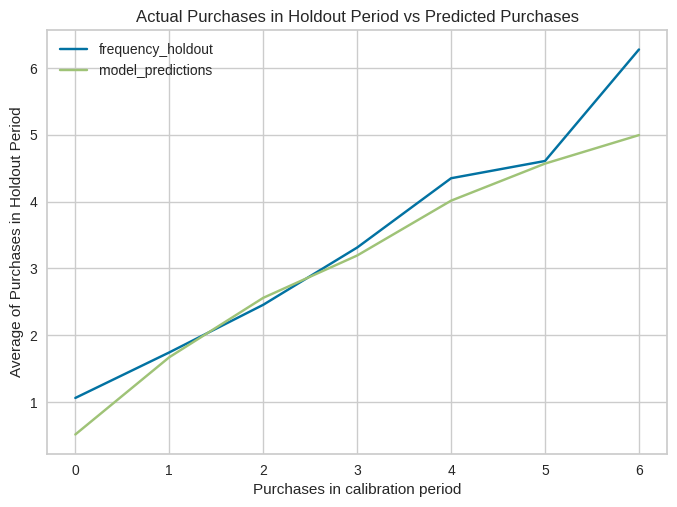

In [ ]:
plot_calibration_purchases_vs_holdout_purchases(model, df_rfmt_cal)

In [ ]:
df_rfmt['predicted_purchases'] = model.conditional_expected_number_of_purchases_up_to_time(180,
                                                                                      df_rfmt['frequency'],
                                                                                      df_rfmt['recency'],
                                                                                      df_rfmt['T'])
df_rfmt.dropna(inplace=True)
# Getting rid of negative values.
df_rfmt = df_rfmt[df_rfmt['monetary_value']>0]
df_rfmt

/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:402: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


,frequency,recency,T,monetary_value,predicted_purchases
CustomerID,,,,,
12347.0,6.0,365.0,367.0,599.701667,2.907443
12348.0,3.0,283.0,358.0,301.480000,1.551483
12352.0,6.0,260.0,296.0,368.256667,3.558751
12356.0,2.0,303.0,325.0,269.905000,1.179166
12358.0,1.0,149.0,150.0,683.200000,1.322508
...,...,...,...,...,...
18272.0,5.0,244.0,246.0,487.752000,3.551025
18273.0,2.0,255.0,257.0,76.500000,1.467653
18282.0,1.0,119.0,126.0,77.840000,1.537811


## Gamma-Gamma Model
Predict average transaction value

In [ ]:
gg_model = GammaGammaFitter()
gg_model.fit(df_rfmt['frequency'], df_rfmt['monetary_value'])

<lifetimes.GammaGammaFitter: fitted with 2790 subjects, p: 2.10, q: 3.45, v: 485.57>

In [ ]:
df_rfmt['pred_monetary'] = gg_model.conditional_expected_average_profit(
        df_rfmt['frequency'],
        df_rfmt['monetary_value'])
df_rfmt

,frequency,recency,T,monetary_value,predicted_purchases,pred_monetary
CustomerID,,,,,,
12347.0,6.0,365.0,367.0,599.701667,2.907443,569.988807
12348.0,3.0,283.0,358.0,301.480000,1.551483,333.762672
12352.0,6.0,260.0,296.0,368.256667,3.558751,376.166864
12356.0,2.0,303.0,325.0,269.905000,1.179166,324.008941
12358.0,1.0,149.0,150.0,683.200000,1.322508,539.930643
...,...,...,...,...,...,...
18272.0,5.0,244.0,246.0,487.752000,3.551025,474.369525
18273.0,2.0,255.0,257.0,76.500000,1.467653,201.781295
18282.0,1.0,119.0,126.0,77.840000,1.537811,260.275833


## CLV Calculation

In [ ]:
df_rfmt['CLV'] = gg_model.customer_lifetime_value(
    model,
    df_rfmt['frequency'],
    df_rfmt['recency'],
    df_rfmt['T'],
    df_rfmt['monetary_value'],
    time = 6,# In months
    )
df_rfmt

,frequency,recency,T,monetary_value,predicted_purchases,pred_monetary,CLV
CustomerID,,,,,,,
12347.0,6.0,365.0,367.0,599.701667,2.907443,569.988807,1600.720228
12348.0,3.0,283.0,358.0,301.480000,1.551483,333.762672,500.175773
12352.0,6.0,260.0,296.0,368.256667,3.558751,376.166864,1293.051981
12356.0,2.0,303.0,325.0,269.905000,1.179166,324.008941,369.036903
12358.0,1.0,149.0,150.0,683.200000,1.322508,539.930643,689.722062
...,...,...,...,...,...,...,...
18272.0,5.0,244.0,246.0,487.752000,3.551025,474.369525,1627.078200
18273.0,2.0,255.0,257.0,76.500000,1.467653,201.781295,286.050141
18282.0,1.0,119.0,126.0,77.840000,1.537811,260.275833,386.611549


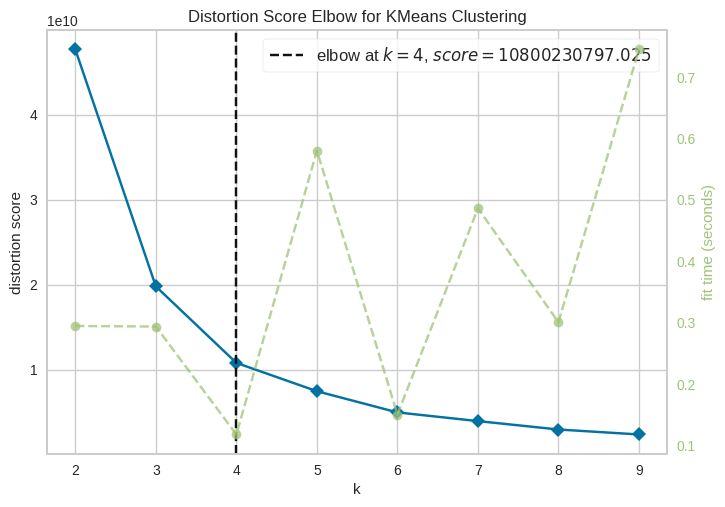

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [ ]:
# Instantiate the clustering model and visualizer
km_model = KMeans()
visualizer = KElbowVisualizer(km_model, k=(2,10))

visualizer.fit(df_rfmt)        # Fit the data to the visualizer
visualizer.show()

In [ ]:
km_model = KMeans(n_clusters=4)
km_model.fit(df_rfmt)
# Creating a new column called cluster whose values are the corresponding cluster for each point.
df_rfmt['cluster'] = km_model.labels_

In [ ]:
# Grouping by clusters
df_clusters = df_rfmt.groupby(['cluster'])['CLV']\
                     .agg(['mean', "count"])\
                     .reset_index()

df_clusters.columns = ["cluster", "avg_CLV", "n_customers"]

df_clusters['perct_customers'] = (df_clusters['n_customers']/df_clusters['n_customers']\
                                  .sum())*100
df_clusters

,cluster,avg_CLV,n_customers,perct_customers
0,0,1113.801710,2760,98.924731
1,1,92846.096709,5,0.179211
2,2,75438.936240,1,0.035842
3,3,23502.728468,24,0.860215


In [ ]:
df_rfmt['customer_category'] = df_rfmt['cluster']\
.replace({3:"Gold", 1:"Diamond", 2:"Silver", 0:"Bronze"})

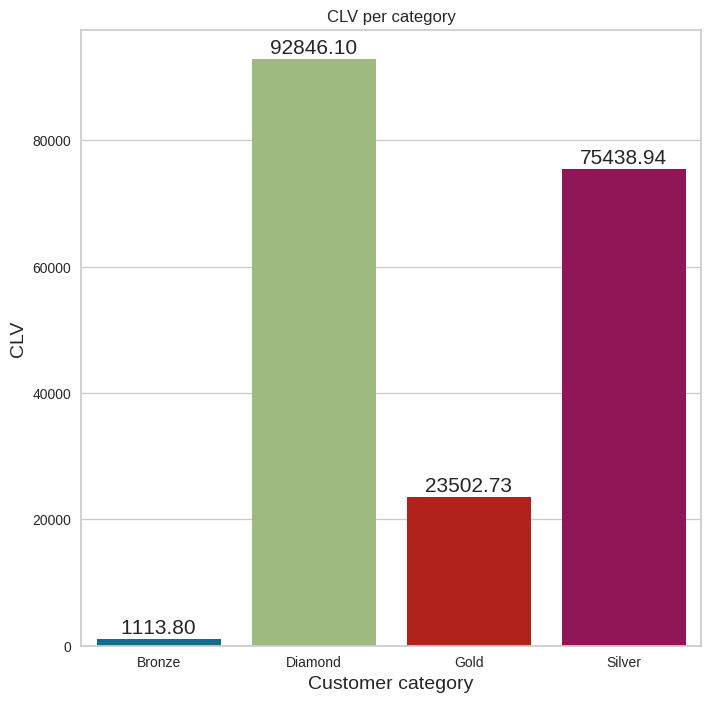

In [ ]:
df_cat = pd.DataFrame(df_rfmt.groupby(['customer_category'])['CLV']\
                      .agg('mean')).reset_index()


# Code source : https://www.geeksforgeeks.org/how-to-annotate-bars-in-barplot-with-matplotlib-in-python/
# Defining the plot size
plt.figure(figsize=(8, 8))

# Defining the values for x-axis, y-axis
# and from which dataframe the values are to be picked
plots = sns.barplot(x="customer_category", y="CLV", data=df_cat)

# Iterating over the bars one-by-one
for bar in plots.patches:

  # Using Matplotlib's annotate function and
  # passing the coordinates where the annotation shall be done
  # x-coordinate: bar.get_x() + bar.get_width() / 2
  # y-coordinate: bar.get_height()
  # free space to be left to make graph pleasing: (0, 8)
  # ha and va stand for the horizontal and vertical alignment
    plots.annotate(format(bar.get_height(), '.2f'),
                   (bar.get_x() + bar.get_width() / 2,
                    bar.get_height()), ha='center', va='center',
                   size=15, xytext=(0, 8),textcoords='offset points')

plt.xlabel("Customer category", size=14)

# Setting the label for y-axis
plt.ylabel("CLV", size=14)

# Setting the title for the graph
plt.title("CLV per category")

# Finally showing the plot
plt.show()

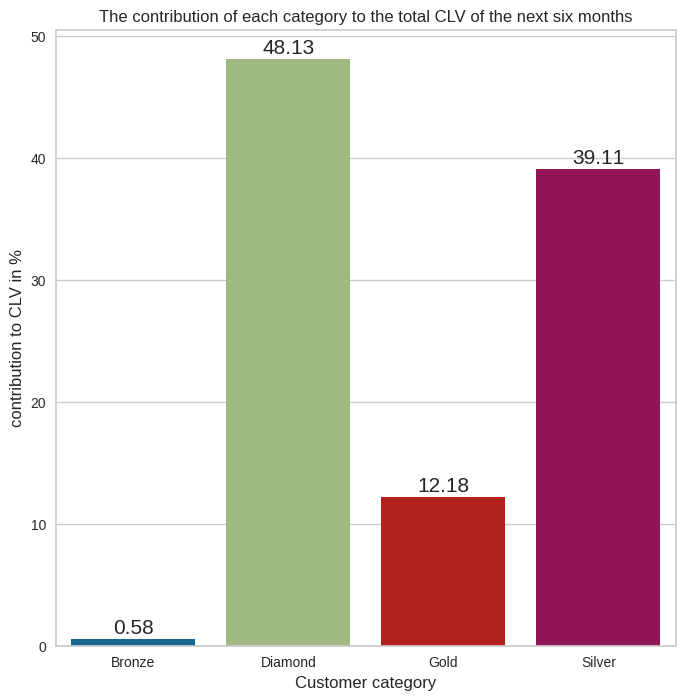

In [ ]:
df_cat["contribution_to_CLV"] = df_cat['CLV']/df_cat['CLV'].sum()*100

# Code source : https://www.geeksforgeeks.org/how-to-annotate-bars-in-barplot-with-matplotlib-in-python/
# Defining the plot size
plt.figure(figsize=(8, 8))

# Defining the values for x-axis, y-axis
# and from which dataframe the values are to be picked
plots = sns.barplot(x="customer_category", y="contribution_to_CLV", data=df_cat)

# Iterating over the bars one-by-one
for bar in plots.patches:

  # Using Matplotlib's annotate function and
  # passing the coordinates where the annotation shall be done
  # x-coordinate: bar.get_x() + bar.get_width() / 2
  # y-coordinate: bar.get_height()
  # free space to be left to make graph pleasing: (0, 8)
  # ha and va stand for the horizontal and vertical alignment
    plots.annotate(format(bar.get_height(), '.2f'),
                   (bar.get_x() + bar.get_width() / 2,
                    bar.get_height()), ha='center', va='center',
                   size=15, xytext=(0, 8),textcoords='offset points')

plt.xlabel("Customer category", size=12)

# Setting the label for y-axis
plt.ylabel("contribution to CLV in %", size=12)

# Setting the title for the graph
plt.title("The contribution of each category to the total CLV of the next six months")

# Finally showing the plot
plt.show()

## Analyze frequency

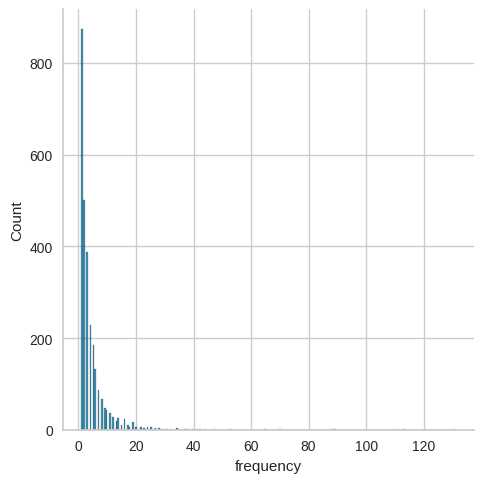

In [ ]:
sns.displot(df_rfmt['frequency'])
plt.show()

Investigate the frequency of each categories

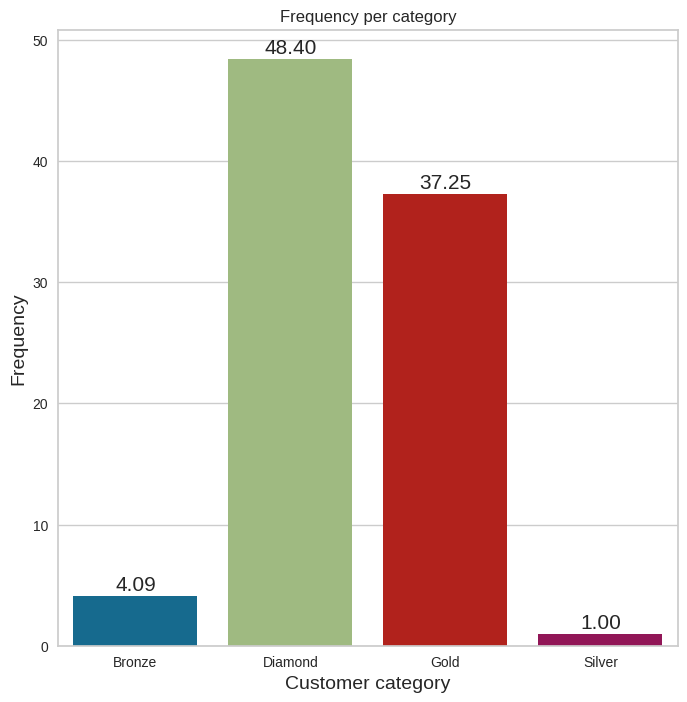

In [ ]:
df_freq = pd.DataFrame(df_rfmt.groupby(['customer_category'])['frequency']\
                              .mean()\
                              .reset_index())


# Code source : https://www.geeksforgeeks.org/how-to-annotate-bars-in-barplot-with-matplotlib-in-python/
# Defining the plot size
plt.figure(figsize=(8, 8))

# Defining the values for x-axis, y-axis
# and from which dataframe the values are to be picked
plots = sns.barplot(x="customer_category", y="frequency", data=df_freq)

# Iterating over the bars one-by-one
for bar in plots.patches:

  # Using Matplotlib's annotate function and
  # passing the coordinates where the annotation shall be done
  # x-coordinate: bar.get_x() + bar.get_width() / 2
  # y-coordinate: bar.get_height()
  # free space to be left to make graph pleasing: (0, 8)
  # ha and va stand for the horizontal and vertical alignment
    plots.annotate(format(bar.get_height(), '.2f'),
                   (bar.get_x() + bar.get_width() / 2,
                    bar.get_height()), ha='center', va='center',
                   size=15, xytext=(0, 8),textcoords='offset points')

plt.xlabel("Customer category", size=14)

# Setting the label for y-axis
plt.ylabel("Frequency", size=14)

# Setting the title for the graph
plt.title("Frequency per category")

# Finally showing the plot
plt.show()

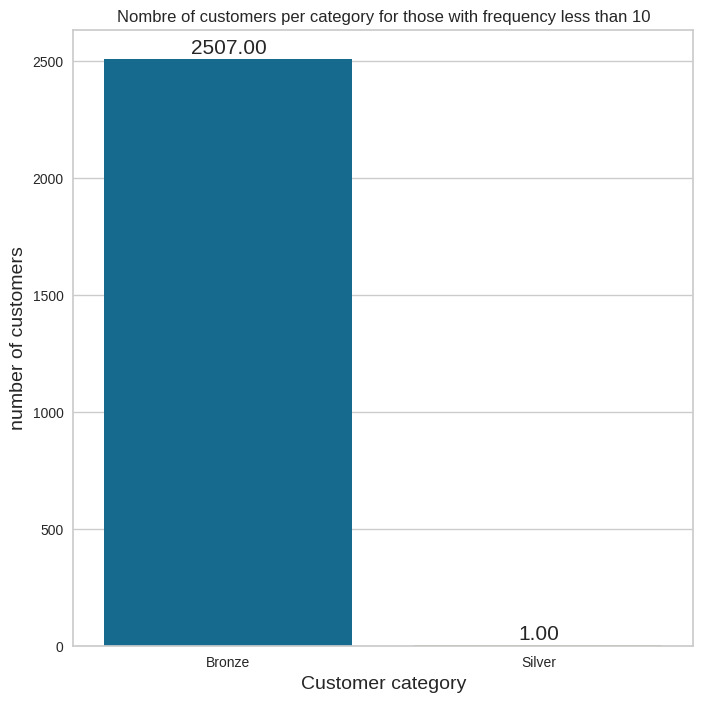

In [ ]:
df_freq_2 = pd.DataFrame(df_rfmt[df_rfmt['frequency'] < 10]\
                        .groupby(['customer_category'])['customer_category']\
                        .agg('count'))

df_freq_2.columns=['n_customers']

df_freq_2 = df_freq_2.reset_index()


# Code source : https://www.geeksforgeeks.org/how-to-annotate-bars-in-barplot-with-matplotlib-in-python/
# Defining the plot size
plt.figure(figsize=(8, 8))

# Defining the values for x-axis, y-axis
# and from which dataframe the values are to be picked
plots = sns.barplot(x="customer_category", y="n_customers", data=df_freq_2)

# Iterating over the bars one-by-one
for bar in plots.patches:

  # Using Matplotlib's annotate function and
  # passing the coordinates where the annotation shall be done
  # x-coordinate: bar.get_x() + bar.get_width() / 2
  # y-coordinate: bar.get_height()
  # free space to be left to make graph pleasing: (0, 8)
  # ha and va stand for the horizontal and vertical alignment
    plots.annotate(format(bar.get_height(), '.2f'),
                   (bar.get_x() + bar.get_width() / 2,
                    bar.get_height()), ha='center', va='center',
                   size=15, xytext=(0, 8),textcoords='offset points')

plt.xlabel("Customer category", size=14)

# Setting the label for y-axis
plt.ylabel("number of customers", size=14)

# Setting the title for the graph
plt.title("Nombre of customers per category for those with frequency less than 10")

# Finally showing the plot
plt.show()

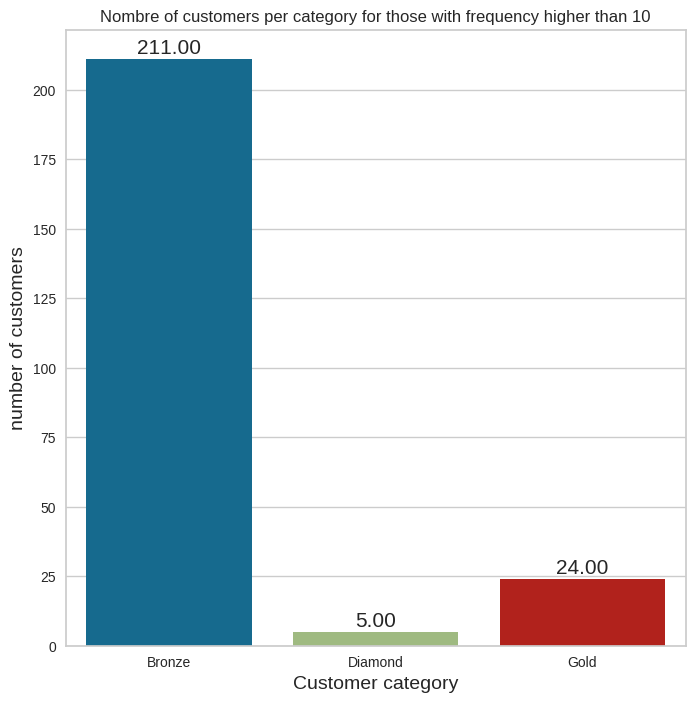

In [ ]:
# Getting the number of customers per category for those with a frequency greater than 10.

df_freq_1 = pd.DataFrame(df_rfmt[df_rfmt['frequency'] > 10]\
                        .groupby(['customer_category'])['customer_category']\
                        .agg('count'))

df_freq_1.columns = ['n_customers']

df_freq_1 = df_freq_1.reset_index()


# Code source : https://www.geeksforgeeks.org/how-to-annotate-bars-in-barplot-with-matplotlib-in-python/
# Defining the plot size
plt.figure(figsize=(8, 8))

# Defining the values for x-axis, y-axis
# and from which dataframe the values are to be picked
plots = sns.barplot(x="customer_category", y="n_customers", data=df_freq_1)

# Iterating over the bars one-by-one
for bar in plots.patches:

  # Using Matplotlib's annotate function and
  # passing the coordinates where the annotation shall be done
  # x-coordinate: bar.get_x() + bar.get_width() / 2
  # y-coordinate: bar.get_height()
  # free space to be left to make graph pleasing: (0, 8)
  # ha and va stand for the horizontal and vertical alignment
    plots.annotate(format(bar.get_height(), '.2f'),
                   (bar.get_x() + bar.get_width() / 2,
                    bar.get_height()), ha='center', va='center',
                   size=15, xytext=(0, 8),textcoords='offset points')

plt.xlabel("Customer category", size=14)

# Setting the label for y-axis
plt.ylabel("number of customers", size=14)

# Setting the title for the graph
plt.title("Nombre of customers per category for those with frequency higher than 10")

# Finally showing the plot
plt.show()

## Analyze the monetary value

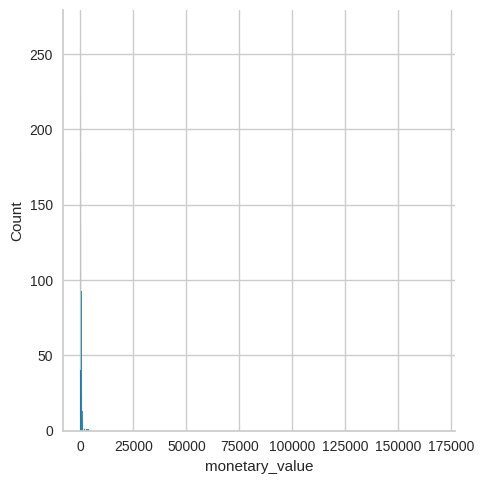

In [ ]:
sns.displot(df_rfmt['monetary_value'])
plt.show()

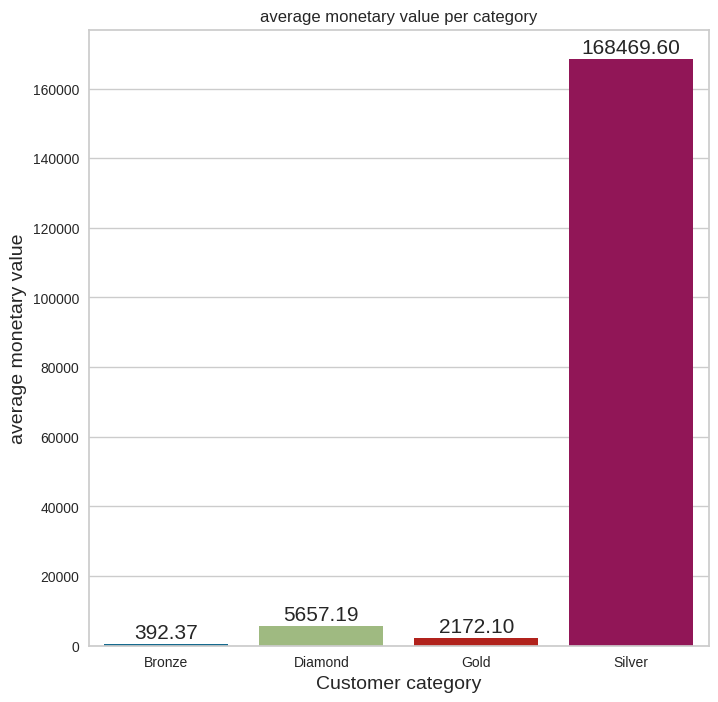

In [ ]:
df_mon = pd.DataFrame(df_rfmt.groupby(['customer_category'])['monetary_value'].mean().reset_index())

# Code source : https://www.geeksforgeeks.org/how-to-annotate-bars-in-barplot-with-matplotlib-in-python/
# Defining the plot size
plt.figure(figsize=(8, 8))

# Defining the values for x-axis, y-axis
# and from which dataframe the values are to be picked
plots = sns.barplot(x="customer_category", y="monetary_value", data=df_mon)

# Iterating over the bars one-by-one
for bar in plots.patches:

  # Using Matplotlib's annotate function and
  # passing the coordinates where the annotation shall be done
  # x-coordinate: bar.get_x() + bar.get_width() / 2
  # y-coordinate: bar.get_height()
  # free space to be left to make graph pleasing: (0, 8)
  # ha and va stand for the horizontal and vertical alignment
    plots.annotate(format(bar.get_height(), '.2f'),
                   (bar.get_x() + bar.get_width() / 2,
                    bar.get_height()), ha='center', va='center',
                   size=15, xytext=(0, 8),textcoords='offset points')

plt.xlabel("Customer category", size=14)

# Setting the label for y-axis
plt.ylabel("average monetary value", size=14)

# Setting the title for the graph
plt.title("average monetary value per category")

# Finally showing the plot
plt.show()

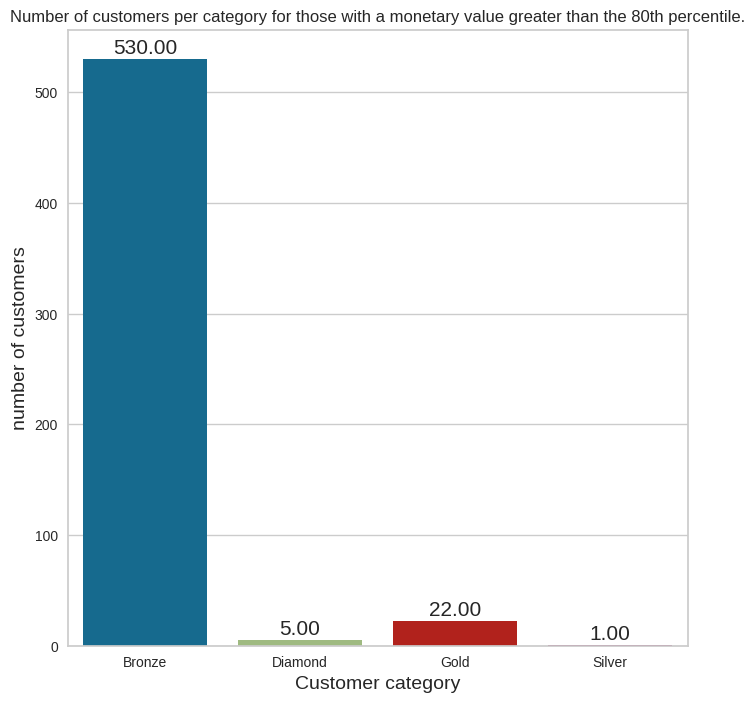

In [ ]:
# Getting the number of customers per category for those with a monetary value greater than the 80th percentile.

# Getting the 80th percentile
perct = df_rfmt['monetary_value'].quantile(q=0.8)

df_mon_1 = pd.DataFrame(df_rfmt[df_rfmt['monetary_value'] > perct]\
                        .groupby(['customer_category'])['customer_category']\
                        .agg('count'))

df_mon_1.columns = ['n_customers']

df_mon_1 = df_mon_1.reset_index()


# Code source : https://www.geeksforgeeks.org/how-to-annotate-bars-in-barplot-with-matplotlib-in-python/
# Defining the plot size
plt.figure(figsize=(8, 8))

# Defining the values for x-axis, y-axis
# and from which dataframe the values are to be picked
plots = sns.barplot(x="customer_category", y="n_customers", data=df_mon_1)

# Iterating over the bars one-by-one
for bar in plots.patches:

  # Using Matplotlib's annotate function and
  # passing the coordinates where the annotation shall be done
  # x-coordinate: bar.get_x() + bar.get_width() / 2
  # y-coordinate: bar.get_height()
  # free space to be left to make graph pleasing: (0, 8)
  # ha and va stand for the horizontal and vertical alignment
    plots.annotate(format(bar.get_height(), '.2f'),
                   (bar.get_x() + bar.get_width() / 2,
                    bar.get_height()), ha='center', va='center',
                   size=15, xytext=(0, 8),textcoords='offset points')

plt.xlabel("Customer category", size=14)

# Setting the label for y-axis
plt.ylabel("number of customers", size=14)

# Setting the title for the graph
plt.title("Number of customers per category for those with a monetary value greater than the 80th percentile.")

# Finally showing the plot
plt.show()

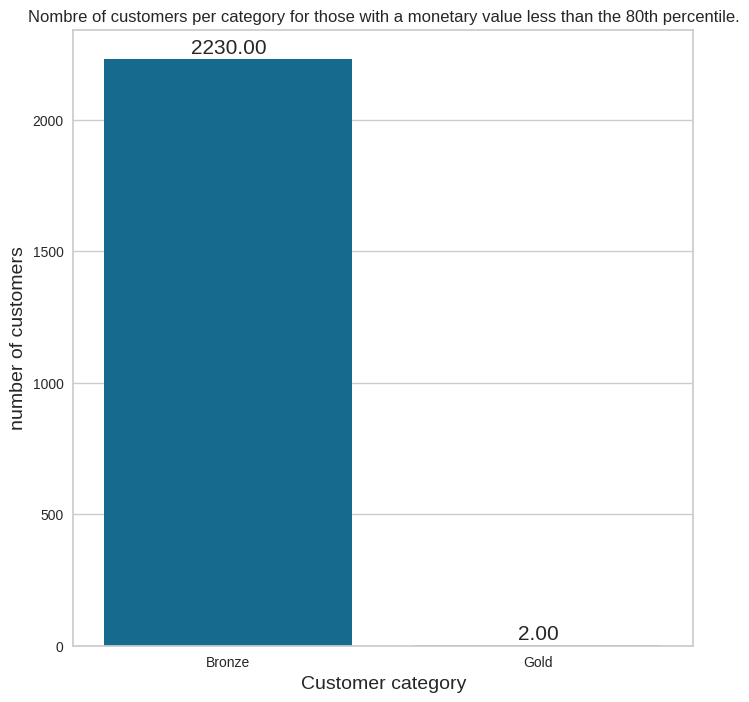

In [ ]:
# Getting the number of customers per category for those with a monetary value less than the 80th percentile.

df_mon_2= pd.DataFrame(df_rfmt[df_rfmt['monetary_value'] < perct]\
                        .groupby(['customer_category'])['customer_category']\
                        .agg('count'))

df_mon_2.columns = ['n_customers']

df_mon_2 = df_mon_2.reset_index()


# Code source : https://www.geeksforgeeks.org/how-to-annotate-bars-in-barplot-with-matplotlib-in-python/
# Defining the plot size
plt.figure(figsize=(8, 8))

# Defining the values for x-axis, y-axis
# and from which dataframe the values are to be picked
plots = sns.barplot(x="customer_category", y="n_customers", data=df_mon_2)

# Iterating over the bars one-by-one
for bar in plots.patches:

  # Using Matplotlib's annotate function and
  # passing the coordinates where the annotation shall be done
  # x-coordinate: bar.get_x() + bar.get_width() / 2
  # y-coordinate: bar.get_height()
  # free space to be left to make graph pleasing: (0, 8)
  # ha and va stand for the horizontal and vertical alignment
    plots.annotate(format(bar.get_height(), '.2f'),
                   (bar.get_x() + bar.get_width() / 2,
                    bar.get_height()), ha='center', va='center',
                   size=15, xytext=(0, 8),textcoords='offset points')

plt.xlabel("Customer category", size=14)

# Setting the label for y-axis
plt.ylabel("number of customers", size=14)

# Setting the title for the graph
plt.title("Nombre of customers per category for those with a monetary value less than the 80th percentile.")

# Finally showing the plot
plt.show()